Methods list:
- count number of data for each y in a partition
- Check if a note is empty
- calculate entropy and mutual information gain
- build tree

# take from CS564 note: special assignment (0 pnts tho) -- ignore this for CS760 HW2
#find the students who have taken all DB classes
#do not use exist but count clause

In [192]:
import pandas as pd
import math
import matplotlib.pyplot as plt
# for visualization
import pydot

In [90]:
def get_entropy(data):
    """
    Calculate entropy
    """
    if data.empty:
        return 0
    Y = data.y
    n0 = len(data[data.y == 0])
    n1 = len(data[data.y == 1])
    p0 = n0/(n1+n0)
    p1 = n1/(n1+n0)
    if n0 == 0:
        hp0 = 0
    else:
        hp0 = - p0*math.log(p0,2)
    if n1 == 0:
        hp1 = 0
    else:
        hp1 = - p1*math.log(p1,2)
    hp = hp1+hp0
    return hp

In [91]:
def info_gain(data, threshold, feature):
    """
    calculate information gain
    """
    # threshold -- integer
    # feature -- string, the feature thta we want to calculate info gain on
    X = data[[feature, 'y']]
    l_data = X[X[feature] >= threshold]  # get left partition where feature's value >= threshold
    r_data = X[X[feature] < threshold]  # get right partition  
    l_p_theta = len(l_data)/len(data)
    r_p_theta = len(r_data)/len(data)
    hy = get_entropy(data)
    hy_theta = l_p_theta*get_entropy(l_data) + r_p_theta*get_entropy(r_data)
    return hy-hy_theta

In [92]:
def find_best_threshold(data):
    largest_gain = 0
    threshold = 0
    feature = None
    features = list(data.drop(['y'],axis = 1).columns)
    for f in features:
        sorted_data = data.sort_values(by=[f])
        for r in range(len(sorted_data)):  # start from 1 to avoid having empty left dataset
            gain = info_gain(data, sorted_data.iloc[r][f], f)
            if gain > largest_gain:
                largest_gain = gain
                threshold = sorted_data.iloc[r][f]
                feature = f
    return largest_gain, threshold, feature

In [93]:
class Leaf:
    """
    A Leaf node, containing final classification (0 or 1)

    """

    def __init__(self, data):
        y1 = len(data[data.y == 1])
        y0 = len(data[data.y == 0])
        if y1 >= y0:
            self.prediction = 1
        else:
            self.prediction = 0

In [94]:
class Stump:
    """A Decision Stump.

    Stump contains "Xj >= t" , two child stumps.
    """

    def __init__(self,
                 threshold,
                 feature,
                 left_branch,
                 right_branch):
        self.threshold = threshold
        self.feature = feature
        self.left_branch = left_branch
        self.right_branch = right_branch

In [113]:
def build_tree(data):
    """
    Builds the tree.
    """

    # Base case 1: empty node
    if data.empty:
#         print("leaf built!")
        return Leaf(data)
    
    gain, threshold, feature = find_best_threshold(data)
#     print("info gain = ", gain)
    # Base case 2: 0 info gain
    if gain == 0:
#         print("leaf built!")
        return Leaf(data)

    left_data = data[data[feature] >= threshold].reset_index(drop=True)
    right_data = data[data[feature] < threshold].reset_index(drop=True)

    # Recursively build the true branch.
    left_branch = build_tree(left_data)

    # Recursively build the false branch.
    right_branch = build_tree(right_data)

    return Stump(threshold, feature, left_branch, right_branch)

In [96]:
def predict_from_single_data(d_tree, data):
    """
    predict every data's y based on its features
    """
    if isinstance(d_tree, Leaf):
        return d_tree.prediction
    if 'y' in list(data.columns):
        X = list(data.drop(['y'],axis = 1).columns)
    else:
        X = list(data.columns)
    for i in range(len(data)):
        for x in X:
            if x == d_tree.feature:
                if data[x].iloc[0] >= d_tree.threshold:
                    return predict_from_single_data(d_tree.left_branch, data)
                else:
                    return predict_from_single_data(d_tree.right_branch, data)

In [97]:
def predict(d_tree, data):
    predictions = []
    for i in range(len(data)):
        row = pd.DataFrame(data.iloc[i]).transpose()
        row = row.reset_index(drop=True)
#         print(row)
        predictions.append(predict_from_single_data(d_tree,row))
    return predictions

In [240]:
def evaluate(d_tree, data):
    pred = predict(d_tree,data)
    true = data.y.tolist()
    correct = 0
    for i in range(len(pred)):
        if pred[i] == true[i]:
            correct +=1
    return correct/len(pred)

In [301]:
def print_tree(stump, spacing=""):
    """World's most elegant tree printing function."""

    # Base case: we've reached a leaf
    if isinstance(stump, Leaf):
        
        print (spacing + "Predict ", stump.prediction)
        return

    # Print the question at this node
    print (spacing + str(stump.feature)+" >= "+str(stump.threshold) + "?")

    # Call this function recursively on the true branch
    print (spacing + 'Then:')
    print_tree(stump.left_branch, spacing + "  |")

    # Call this function recursively on the false branch
    print (spacing + 'Else:')
    print_tree(stump.right_branch, spacing + "  |")

In [99]:
def read_txt(filename):
    data = pd.read_csv(filename,sep=" ", header = None)
    data.columns = ["x1","x2","y"]
    return data

In [26]:
#read data from txt file
data = pd.read_csv('D2.txt', sep=" ", header=None)
data.columns = ["x1", "x2", "y"]

In [399]:
training_set = data.sample(frac = 0.8, random_state=1)
test_set = pd.concat([training_set, data]).drop_duplicates(keep=False)

In [400]:
my_tree = build_tree(training_set)

In [401]:
pred = predict(my_tree, test_set)
count = 0
for i in range(len(pred)):
    if(test_set.iloc[i]['y']== pred[i]):
        count += 1
print(count/len(pred))
    

0.945


# Question 2 small data set visualization

In [12]:
sample = pd.DataFrame({"x1":[1,1,2,2], "x2":[1,2,1,2],"y":[0,1,1,0] })
sample

,x1,x2,y
0,1,1,0
1,1,2,1
2,2,1,1
3,2,2,0


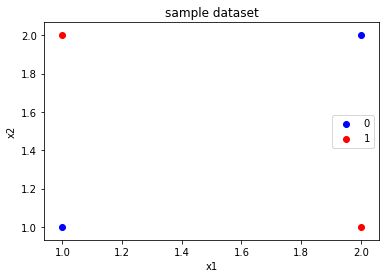

In [42]:
fig, ax = plt.subplots()
scatter1 = ax.scatter([1,2],[1,2],label = '0', color = 'blue')
scatter1 = ax.scatter([1,2],[2,1], label = '1',color = 'red')
plt.title('sample dataset')
plt.xlabel('x1')
plt.ylabel('x2')
ax.legend()
plt.savefig('question2.pdf')

In [27]:
q2_tree = build_tree(sample)

info gain =  0
leaf built!


In [35]:
force_partition = sample.iloc[[0,1]]
force_partition

,x1,x2,y
0,1,1,0
1,1,2,1


In [36]:
q2_test_tree = build_tree(force_partition)

info gain =  1.0
info gain =  0
leaf built!
info gain =  0
leaf built!


# Qeustion 3

In [100]:
# Druns = pd.read_csv('D2.txt', sep=" ", header=None)
# data.columns = ["x1", "x2", "y"]
druns = read_txt("Druns.txt")

In [101]:
def q3_find_best_threshold(data):
    question3_dic = dict();
    threshold = 0
    feature = None
    features = list(data.drop(['y'],axis = 1).columns)
    for f in features:
        sorted_data = data.sort_values(by=[f])
        for r in range(len(sorted_data)):  # start from 1 to avoid having empty left dataset
            key = f+" >= "+str(sorted_data.iloc[r][f])
            gain = info_gain(data, sorted_data.iloc[r][f], f)
            question3_dic.update({key: round(gain,4)})
    return question3_dic

In [102]:
q3_find_best_threshold(druns)

{'x1 >= 0.0': 0.0,
 'x1 >= 0.1': 0.0442,
 'x2 >= -2.0': 0.0,
 'x2 >= -1.0': 0.0442,
 'x2 >= 0.0': 0.0383,
 'x2 >= 1.0': 0.0049,
 'x2 >= 2.0': 0.0011,
 'x2 >= 3.0': 0.0163,
 'x2 >= 4.0': 0.0495,
 'x2 >= 5.0': 0.1052,
 'x2 >= 6.0': 0.1996,
 'x2 >= 7.0': 0.0383,
 'x2 >= 8.0': 0.1891}

In [72]:
druns

,x1,x2,y
0,0.1,-2,0
1,0.0,-1,1
2,0.0,0,0
3,0.0,1,0
4,0.0,2,0
5,0.0,3,0
6,0.0,4,0
7,0.0,5,0
8,0.0,6,1
9,0.0,7,0


# Question 4

In [105]:
D3 = read_txt("D3leaves.txt")

In [106]:
q4_tree = build_tree(D3)

info gain =  0.3219280948873623
info gain =  0
leaf built!
info gain =  1.0
info gain =  0
leaf built!
info gain =  0
leaf built!


In [107]:
print_tree(q4_tree)

x1 >= 10?
Then:
  Predict  1
Else:
  x2 >= 3?
  Then:
    Predict  1
  Else:
    Predict  0


# Question5


In [129]:
D1 = read_txt("D1.txt")

In [130]:
q5_tree1 = build_tree(D1)

In [110]:
print_tree(q5_tree1)

x2 >= 0.201829?
Then:
  Predict  1
Else:
  Predict  0


In [147]:
G = viz_tree(q5_tree1)
pos =nx.spring_layout(G)
print(pos)
# nx.draw(G)

{'ROOT': array([0., 0.])}


In [111]:
D2 = read_txt("D2.txt")

In [185]:
q5_tree2 = build_tree(D2)

In [302]:
print_tree(q5_tree2)

x1 >= 0.533076?
Then:
  |x2 >= 0.383738?
  |Then:
  |  |x1 >= 0.5503640000000001?
  |  |Then:
  |  |  |Predict  1
  |  |Else:
  |  |  |x2 >= 0.474971?
  |  |  |Then:
  |  |  |  |Predict  1
  |  |  |Else:
  |  |  |  |Predict  0
  |Else:
  |  |x1 >= 0.761423?
  |  |Then:
  |  |  |x2 >= 0.191206?
  |  |  |Then:
  |  |  |  |Predict  1
  |  |  |Else:
  |  |  |  |x1 >= 0.9048200000000001?
  |  |  |  |Then:
  |  |  |  |  |x2 >= 0.037708?
  |  |  |  |  |Then:
  |  |  |  |  |  |x1 >= 0.930371?
  |  |  |  |  |  |Then:
  |  |  |  |  |  |  |Predict  1
  |  |  |  |  |  |Else:
  |  |  |  |  |  |  |x1 >= 0.927522?
  |  |  |  |  |  |  |Then:
  |  |  |  |  |  |  |  |Predict  0
  |  |  |  |  |  |  |Else:
  |  |  |  |  |  |  |  |Predict  1
  |  |  |  |  |Else:
  |  |  |  |  |  |Predict  0
  |  |  |  |Else:
  |  |  |  |  |x2 >= 0.169053?
  |  |  |  |  |Then:
  |  |  |  |  |  |x1 >= 0.850316?
  |  |  |  |  |  |Then:
  |  |  |  |  |  |  |Predict  1
  |  |  |  |  |  |Else:
  |  |  |  |  |  |  |Predict  0
  |

# Question 6 

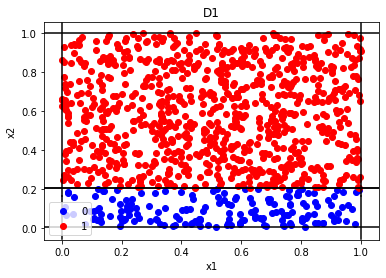

In [366]:
pred1 = predict(q5_tree1,D1)
x10 = []
x20 =[]
x11 =[]
x21 = []
for i in range(len(pred1)):
    if pred1[i] == 0:
        x10.append(D1.iloc[i].x1)
        x20.append(D1.iloc[i].x2)
    else:
        x11.append(D1.iloc[i].x1)
        x21.append(D1.iloc[i].x2)   
fig,ax = plt.subplots()
scatter1 = ax.scatter(x10,x20, label = '0', color = 'blue')
scatter1 = ax.scatter(x11,x21, label = '1',color = 'red')
plt.title('D1')
plt.xlabel('x1')
plt.ylabel('x2')
ax.legend()
ax = print_boundry(q5_tree1,fig,ax,min(D1.x1),max(D1.x1),min(D1.x2),max(D1.x2))
plt.savefig("question6_1.pdf")

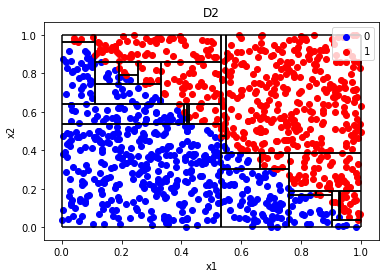

In [396]:
pred2 = predict(q5_tree2,D2)
x10 = []
x20 =[]
x11 =[]
x21 = []
for i in range(len(pred1)):
    if pred2[i] == 0:
        x10.append(D2.iloc[i].x1)
        x20.append(D2.iloc[i].x2)
    else:
        x11.append(D2.iloc[i].x1)
        x21.append(D2.iloc[i].x2)   
fig,ax = plt.subplots()
scatter1 = ax.scatter(x10,x20, label = '0', color = 'blue')
scatter1 = ax.scatter(x11,x21, label = '1',color = 'red')
plt.title('D2')
plt.xlabel('x1')
plt.ylabel('x2')
ax.legend()
ax = print_boundry(q5_tree2,fig,ax,min(D2.x1),max(D2.x1),min(D2.x2),max(D2.x2))
# plt.savefig("question6_1.pdf")
plt.savefig('question6_2.pdf')

In [395]:
def print_boundry(stump, fig,ax,x1min,x1max,x2min,x2max):
    """World's most elegant tree printing function."""
#     ax.hlines(y = x2min, xmin = x1min, xmax = x1max,color='black')
#     ax.hlines(y = x2max, xmin = x1min, xmax = x1max,color='black')
#     ax.vlines(x=x1min, ymin=x2min, ymax=x2max,color='black')
#     ax.vlines(x=x1max, ymin=x2min, ymax=x2max,color='black')
    # Base case: we've reached a leaf
    if isinstance(stump, Leaf):
        ax.hlines(y = x2min, xmin = x1min, xmax = x1max,color='black')
        ax.hlines(y = x2max, xmin = x1min, xmax = x1max,color='black')
        ax.vlines(x=x1min, ymin=x2min, ymax=x2max,color='black')
        ax.vlines(x=x1max, ymin=x2min, ymax=x2max,color='black')
        return ax

    # Call this function recursively on the true branch
    if stump.feature == 'x1':
        print_boundry(stump.left_branch, fig,ax,stump.threshold,x1max,x2min,x2max)
    elif stump.feature == 'x2':
        print_boundry(stump.left_branch, fig,ax,x1min,x1max,stump.threshold,x2max)

    # Call this function recursively on the false branch
    if stump.feature == 'x1':
        print_boundry(stump.right_branch, fig,ax,x1min,stump.threshold,x2min,x2max)
    elif stump.feature == 'x2':
        print_boundry(stump.right_branch, fig,ax,x1min,x1max,x2min,stump.threshold)
        
    return ax

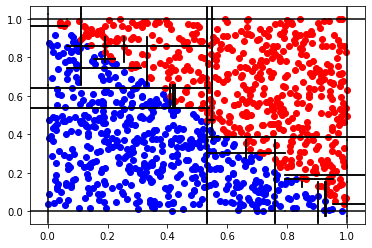

In [363]:
fig,ax = plt.subplots()
# f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
scatter1 = ax.scatter(x10,x20, label = '0', color = 'blue')
scatter2 = ax.scatter(x11,x21, label = '1',color = 'red')
ax = print_boundry(q5_tree2,fig,ax,min(D1.x1),max(D1.x1),min(D1.x2),max(D1.x2))
plt.savefig("question6_2.pdf")

# Question 7


In [201]:
Dbig = read_txt("Dbig.txt")

In [229]:
D8192 = Dbig.sample(8192)
test_set = pd.concat([D8192,Dbig]).drop_duplicates(keep = False)
D32 = D8192.iloc[:32]
D128 = D8192.iloc[:128]
D512 = D8192.iloc[:512]
D2048 = D8192.iloc[:2048]

In [234]:
def tree_traversal(stump):
    cnt = 1
    # Base case: we've reached a leaf
    if isinstance(stump, Leaf):
        return 1

    # Call this function recursively on the true branch
    cnt += tree_traversal(stump.left_branch)

    # Call this function recursively on the false branch
    cnt += tree_traversal(stump.right_branch)
    
    return cnt

tree_traversal(q5_tree2)

In [236]:
tree32 = build_tree(D32)

In [241]:
evaluate(tree32,test_set)

0.8158185840707964

In [242]:
tree_traversal(tree32)

7

In [252]:
sizes = [32,128,512,2048,8192]
data = [D32,D128,D512,D2048,D8192]
err = []
n_nodes = []
trees = []
for i in range(len(sizes)):
    tree = build_tree(data[i])
    score = evaluate(tree, test_set)
    print("size "+str(sizes[i]) + ": " + str(score))
    err.append(score)
    n_nodes.append(tree_traversal(tree))
    trees.append(tree)

size 32: 0.8158185840707964
size 128: 0.9048672566371682
size 512: 0.9546460176991151
size 2048: 0.980641592920354
size 8192: 0.9845132743362832


In [253]:
print(err)

[0.8158185840707964, 0.9048672566371682, 0.9546460176991151, 0.980641592920354, 0.9845132743362832]


In [268]:
print("Nodes number")
for i in range(len(n_nodes)):
    print('D'+str(sizes[i]) +": " +str(n_nodes[i]))

Nodes number
D32: 7
D128: 27
D512: 43
D2048: 129
D8192: 229


In [257]:
print_tree(trees[0])

x1 >= -0.711326?
Then:
  x1 >= 0.795968?
  Then:
    Predict  1
  Else:
    x2 >= -0.823795?
    Then:
      Predict  0
    Else:
      Predict  1
Else:
  Predict  1


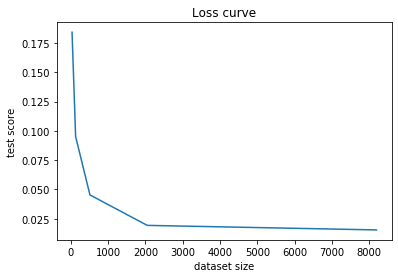

In [294]:
test_err = [(1-o) for o in err]
plt.plot(sizes,test_err)
plt.title("Loss curve")
plt.xlabel("dataset size")
plt.ylabel("test score")
plt.savefig("loss_curve.pdf")

# Question 8

In [289]:
for i in range(len(data)):
    t_d = pd.DataFrame(data[i].reset_index(drop = True))
    t_d = t_d.rename({'y': 'catagory'},axis = 1)#, inplace=True)
    print(t_d)
    t_d.to_csv("D"+str(sizes[i])+".csv")

          x1        x2  catagory
0   0.795968 -0.390917         1
1   0.673278  0.050048         0
2   0.052658 -0.823795         0
3   1.319713 -0.829256         1
4  -0.293081  0.100801         0
5   0.283237 -1.445828         1
6   0.623188  0.256705         0
7  -1.011274 -1.100074         1
8  -0.699330  0.731005         0
9   1.026978 -1.444782         1
10  0.862535 -0.279800         1
11  0.071122 -0.610232         0
12  0.568807  0.863138         0
13 -0.810040 -0.523914         1
14 -1.491062  0.562989         1
15 -1.204040 -0.586166         1
16  0.530695  0.390884         0
17  0.241883 -0.025691         0
18  1.155015 -0.445850         1
19 -0.711326  0.155894         0
20  0.169034 -0.556384         0
21  0.033869  0.260159         0
22 -0.671686  0.680367         0
23  0.079197 -1.399672         1
24 -1.425365  0.903429         1
25  1.285606  1.275912         1
26 -1.095356 -0.736668         1
27 -1.265844  1.060137         1
28  1.131774 -0.956300         1
29  0.9796

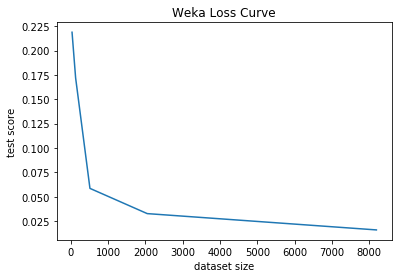

In [299]:
weka_err = [0.21875, 0.171875, 0.058594, 0.032715, 0.015991]
plt.plot(sizes,weka_err)
plt.title("Weka Loss Curve")
plt.xlabel("dataset size")
plt.ylabel("test score")
plt.savefig("weka.pdf")

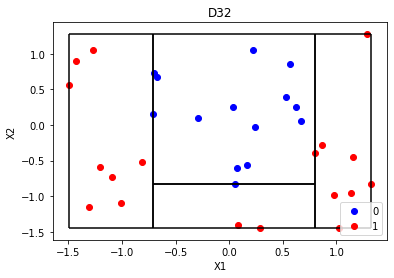

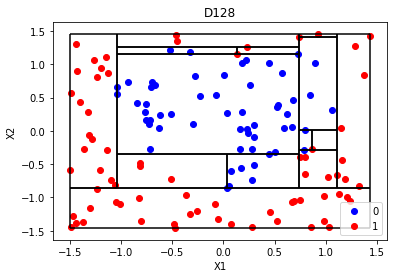

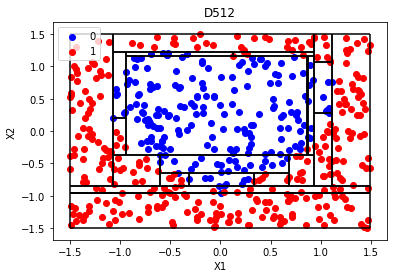

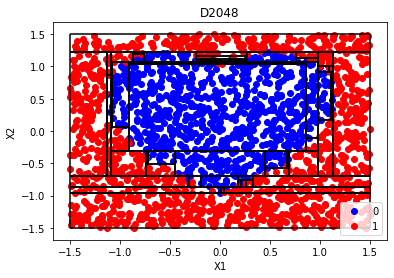

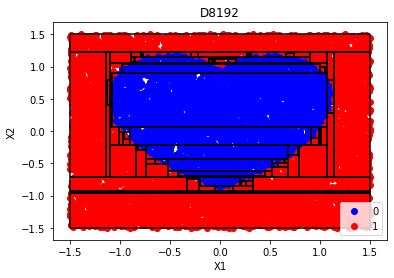

In [397]:
for i in range(len(trees)):
#     print(evaluate(trees[i],data[i]))
    pred = predict(trees[i],data[i])
    x10 = []
    x20 =[]
    x11 =[]
    x21 = []
    fig,ax = plt.subplots()
    for k in range(len(pred)):
        if pred[k] == 0:
            x10.append(data[i].iloc[k].x1)
            x20.append(data[i].iloc[k].x2)
        else:
            x11.append(data[i].iloc[k].x1)
            x21.append(data[i].iloc[k].x2)   
    scatter1 = ax.scatter(x10,x20, label = '0', color = 'blue')
    scatter1 = ax.scatter(x11,x21, label = '1',color = 'red')
    plt.title("D"+str(sizes[i]))
    plt.xlabel('X1')
    plt.ylabel('X2')
    ax.legend()
    ax = print_boundry(trees[i],fig,ax,min(data[i].x1),max(data[i].x1),min(data[i].x2),max(data[i].x2))
    plt.savefig("question7"+str(i)+".pdf")
    plt.show()
    ax.clear()